In [5]:
# GENERAL PACKAGE IMPORT
# ----------------------
from db_interface import DB_Interface
import requests
import numpy as np
import json
import pandas as pd
from pandas import DataFrame
from io import StringIO

import datetime as dt
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.dates import date2num
import seaborn
import timeit
import json
import pickle

import matplotlib.pyplot as plt
#import oa_temp as oa
#import sa_temp as sa
import datetime
import db_plotting

In [6]:
data20 = pd.read_csv('data20_revised.csv', index_col = 0, parse_dates = True)
data21 = pd.read_csv('data21_revised.csv', index_col = 0, parse_dates = True)

In [7]:
data20['datetime'] = pd.to_datetime(data20['datetime'])
data21['datetime'] = pd.to_datetime(data21['datetime'])

In [8]:
print(type(data21['datetime'].iloc[0]))
print(type(datetime.time(14,0,0)))

data20['date'] = data20['datetime'].apply(lambda x: datetime.date(x.year, x.month, x.day))
data20['time'] = data20['datetime'].apply(lambda x: datetime.time(x.hour, x.minute, x.second))

data21['date'] = data21['datetime'].apply(lambda x: datetime.date(x.year, x.month, x.day))
data21['time'] = data21['datetime'].apply(lambda x: datetime.time(x.hour, x.minute, x.second))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'datetime.time'>


In [9]:
print(data20.columns)

Index(['desk1_6_light_power', 'desk1_plug_power', 'desk2_light_power',
       'desk2_plug_power', 'desk3_light_power', 'desk3_plug_power',
       'desk4_light_power', 'desk4_plug_power', 'desk5_light_power',
       'desk5_plug_power', 'desk6_plug_power', '1A-VAV1-Zn_Temp',
       '1A-VAV2-Zn_Temp', '1A-VAV3-Zn_Temp', '1A-VAV1-OccupiedCoolingSetpt',
       '1A-VAV1-OccupiedHeatingSetpt', '1A-VAV1-UnoccupiedCoolingSetpt',
       '1A-VAV1-UnoccupiedHeatingSetpt', '1A-VAV2-OccupiedCoolingSetpt',
       '1A-VAV2-OccupiedHeatingSetpt', '1A-VAV2-UnoccupiedCoolingSetpt',
       '1A-VAV2-UnoccupiedHeatingSetpt', '1A-VAV3-OccupiedCoolingSetpt',
       '1A-VAV3-OccupiedHeatingSetpt', '1A-VAV3-UnoccupiedCoolingSetpt',
       '1A-VAV3-UnoccupiedHeatingSetpt', '1A-El-AHU', '1A-El-CHWP',
       '1A-El-Exhaust Fan', '1A-El-HWP', '1A-Th-Chilled Water', '1B-OAT-1',
       'datetime', 'date', 'time'],
      dtype='object')


### Metrics

In [10]:
data20 = data20.assign(COP='COP') 
#data20['COP'] = data20['oat_C'].apply(lambda x: (0.548 + 0.0951*x + (-7.63E-04)*x**2))
data20['COP'] = 2.9
data21 = data21.assign(COP='COP') 
#data21['COP'] = data21['oat_C'].apply(lambda x: (0.548 + 0.0951*x + (-7.63E-04)*x**2))
data21['COP'] = 2.9

In [11]:
data20 = data20.assign(chiller = 'Chiller_load') 
data20['Chiller_load'] = (data20['1A-Th-Chilled Water']/data20['COP']) *-1
data20['cooling_power [W]'] = data20['1A-El-AHU'] + data20['1A-El-Exhaust Fan'] + data20['1A-El-CHWP'] + data20['Chiller_load']

data21 = data21.assign(chiller = 'Chiller_load') 
data21['Chiller_load'] = (data21['1B-Th-Chilled Water']/data21['COP']) *-1
data21['cooling_power [W]'] = data21['1B-El-AHU'] + data21['1B-El-Exhaust Fan'] + data21['1B-El-CHWP'] + data21['Chiller_load']

In [12]:
en_1a = []
en_1b = []

# define dates for the calculation
for day in range(10, 16):    
    mask_1 = data21['date'] == datetime.date(2021, 8, day)
    print(day)
    day_en_1a = round((data20['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1a.append(day_en_1a)
      
    day_en_1b = round((data21['cooling_power [W]'][mask_1].sum()/4000),2)
    en_1b.append(day_en_1b)
print(en_1a)

10
11
12
13
14
15
[17.92, 18.01, 18.5, 19.44, 20.49, 20.59]


C:\Users\agarw\Desktop\LBNL\BTUS - HIL\Test results\HIL-Sim-main_process\HIL-Sim-main\flexlab\db_layer\db_plotting.py:38: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(hspace = .2, wspace=.15)


['08/09', '08/10', '08/11', '08/12', '08/13', '08/14', '08/15']
[datetime.date(2021, 8, 9), datetime.date(2021, 8, 10), datetime.date(2021, 8, 11), datetime.date(2021, 8, 12), datetime.date(2021, 8, 13), datetime.date(2021, 8, 14), datetime.date(2021, 8, 15)]
6
[17.92, 18.01, 18.5, 19.44, 20.49, 20.59]


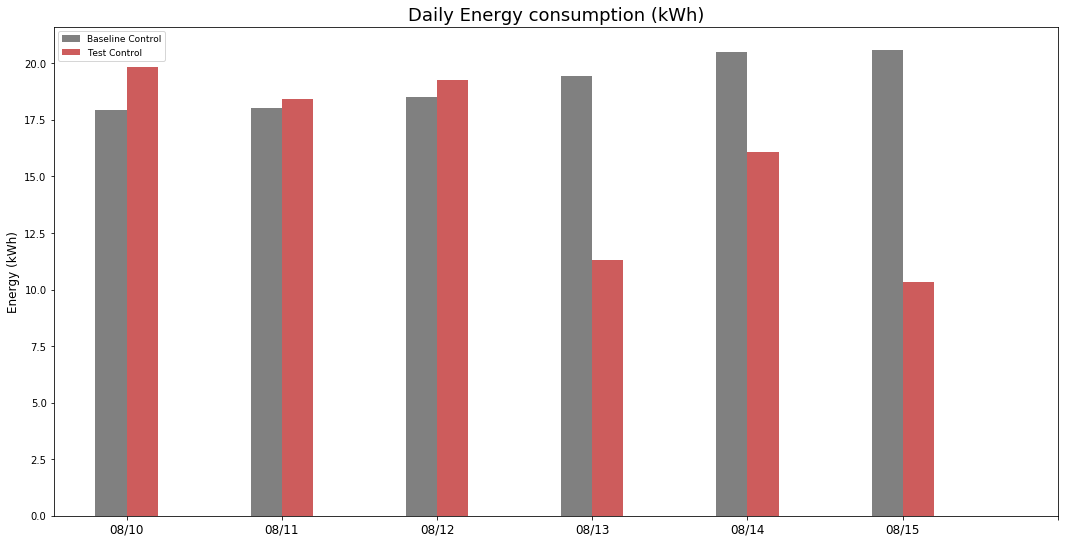

In [13]:
db_plotting.energy_plot(data21, en_1a, en_1b, 'Daily Energy consumption (kWh)', 'Energy (kWh)')

### Thermal comfort

In [14]:
data20 = data20.assign(nor_zat_deg = 'nor_zat_deg') 
#for i in range(len(data20.index)):

def zat_col(df_zat, df_cool_sp):
    df_zat = df_zat.apply(lambda x: (x-32)/1.8)
    df_cool_sp = df_cool_sp.apply(lambda x: (x-32)/1.8)
    
    df_zat_deg = df_zat - df_cool_sp
    df_zat_deg = df_zat_deg.apply(lambda x:0 if x <= 0 else x)
    return (df_zat_deg)

In [15]:
data20['nor_zat_deg'] = zat_col(data20['1A-VAV1-Zn_Temp'], data20['1A-VAV1-OccupiedCoolingSetpt'])
data20['cor_zat_deg'] = zat_col(data20['1A-VAV3-Zn_Temp'], data20['1A-VAV2-OccupiedCoolingSetpt'])
data20['sou_zat_deg'] = zat_col(data20['1A-VAV3-Zn_Temp'], data20['1A-VAV3-OccupiedCoolingSetpt'])

data21['nor_zat_deg'] = zat_col(data21['1B-VAV1-Zn_Temp'], data21['1B-VAV1-OccupiedCoolingSetpt'])
data21['cor_zat_deg'] = zat_col(data21['1B-VAV2-Zn_Temp'], data21['1B-VAV2-OccupiedCoolingSetpt'])
data21['sou_zat_deg'] = zat_col(data21['1B-VAV3-Zn_Temp'], data21['1B-VAV3-OccupiedCoolingSetpt'])

In [16]:
def calc_stats(df, df_temp):
   
    overshoot = []
    mean = []
    median = []
    std = []
    oc_st = datetime.time(7,0,0)
    oc_en = datetime.time(19,0,0)

    oc_time = ((df['time'] >= oc_st) & (df['time'] <= oc_en))

    #print(df_temp, df['Tcool_SP'])
        
    for day in range(9, 16):    
        mask_1 = data21['date'] == datetime.date(2021, 8, day)
        daily_mean = df_temp[mask_1][oc_time].mean()
        daily_median = df_temp[mask_1][oc_time].median()
        #print('Variance', df[df[i] > target[i]].var())
        daily_std = df_temp[mask_1][oc_time].std()
        
        mean.append(daily_mean)
        median.append(daily_median)
        std.append(daily_std)
        
    #for i in range(len(df.index)):
        #if (df['time'][i] <= oc_en) & (df['time'][i] >= oc_st):
        #print(df_temp[i], df['Tcool_SP'][i], df_temp[i] - df['Tcool_SP'][i])
        daily_shoot = sum(df_temp[mask_1][oc_time]*.25)
        counter = sum(df_temp[mask_1][oc_time]>0)
        overshoot.append(daily_shoot)
        
        #print(day)
    #print(mean, median, std)
    
    return(overshoot, mean, median, std)

In [17]:
data20_nor_zat_deg, data20_nor_mean, data20_nor_median, data20_nor_std = calc_stats(data20, data20['nor_zat_deg'])
data20_cor_zat_deg, data20_cor_mean, data20_cor_median, data20_cor_std = calc_stats(data20, data20['cor_zat_deg'])
data20_sou_zat_deg, data20_sou_mean, data20_sou_median, data20_sou_std = calc_stats(data20, data20['sou_zat_deg'])

data21_nor_zat_deg, data21_nor_mean, data21_nor_median, data21_nor_std = calc_stats(data21, data21['nor_zat_deg'])
data21_cor_zat_deg, data21_cor_mean, data21_cor_median, data21_cor_std = calc_stats(data21, data21['cor_zat_deg'])
data21_sou_zat_deg, data21_sou_mean, data21_sou_median, data21_sou_std = calc_stats(data21, data21['sou_zat_deg'])

In [18]:
print(data20_nor_zat_deg, data20_nor_mean, data21_nor_median, data21_nor_std)

[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [19]:
scenario_dict = {}
scenario_dict[1] = calc_stats(data20, data20['nor_zat_deg'])
scenario_dict[2] = calc_stats(data20, data20['cor_zat_deg'])
scenario_dict[3] = calc_stats(data20, data20['sou_zat_deg'])

scenario_dict[4] = calc_stats(data21, data21['nor_zat_deg'])
scenario_dict[5] = calc_stats(data21, data21['cor_zat_deg'])
scenario_dict[6] = calc_stats(data21, data21['sou_zat_deg'])

scenario_dict = {'data20': {"nor": calc_stats(data20, data20['nor_zat_deg']),
                            "cor": calc_stats(data20, data20['cor_zat_deg']), 
                            "sou": calc_stats(data20, data20['sou_zat_deg'])}, 
                 
                 'data21': {"nor": calc_stats(data21, data21['nor_zat_deg']),
                            "cor": calc_stats(data21, data21['cor_zat_deg']), 
                            "sou": calc_stats(data21, data21['sou_zat_deg'])}}

In [20]:
print(scenario_dict['data21']['sou'])
print(scenario_dict['data21']['sou'][0][1:5])

([0, 0.3104431216931216, 0.11601851851851297, 0.12453703703703578, 0.5385185185185319, 0.1458664021164049, 0.5583333333333416], [nan, 0.02534229564841809, 0.009470899470899017, 0.010166288737717206, 0.04396069538926791, 0.011907461397257542, 0.04557823129251768], [nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [nan, 0.05009379308132298, 0.028305885195785908, 0.03219658597965566, 0.08245442562406036, 0.02769832228546456, 0.08225781984955588])
[0.3104431216931216, 0.11601851851851297, 0.12453703703703578, 0.5385185185185319]


In [21]:
print(sum(data20_nor_zat_deg), sum(data21_nor_zat_deg))
print(sum(data20_cor_zat_deg), sum(data21_cor_zat_deg))
print(sum(data20_sou_zat_deg), sum(data21_sou_zat_deg))

0.0 0.0
0.8865343915343562 0.18095899470898225
0.8865343915343562 1.7937169312169488


C:\Users\agarw\Desktop\LBNL\BTUS - HIL\Test results\HIL-Sim-main_process\HIL-Sim-main\flexlab\db_layer\db_plotting.py:146: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(hspace = .2, wspace=.15)


['08/09', '08/10', '08/11', '08/12', '08/13', '08/14', '08/15']
[0 1 2 3 4 5]


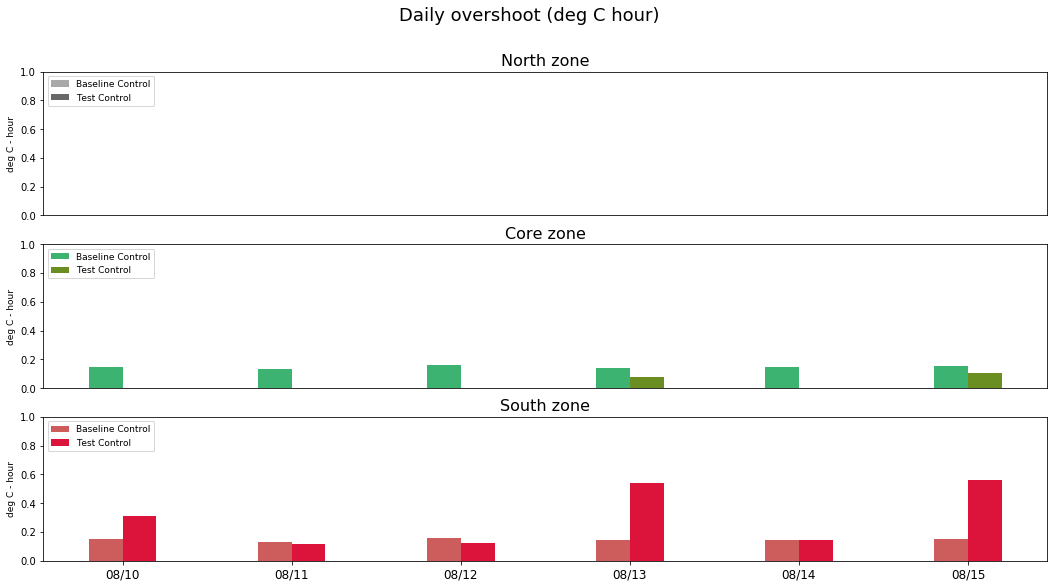

In [22]:
# key for metrics to be plotted in the scenario dictionary; {1:'overshoot', 2:'mean', 3:'median', 4:'std_dev'}
title_dict = {1: 'Daily overshoot (deg C hour)', 2:'Daily overshoot (mean)', 3:'Daily overshoot (median)' , 
              4:'Daily overshoot (standard deviation)'}
ylabel = {1: 'deg C - hour', 2: 'deg C', 3: 'deg C', 4: 'deg C'}
db_plotting.thermal_comfort_plot(data20, scenario_dict['data20']['nor'], scenario_dict['data21']['nor'], 
                                 scenario_dict['data20']['cor'], scenario_dict['data21']['cor'], 
                                 scenario_dict['data20']['sou'], scenario_dict['data21']['sou'], 
                                 scenario_dict, 0, ylabel[1], title_dict[1])